# Homework 4

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import jaccard_score
import glob
from scipy.signal import convolve2d
from skimage.feature import hog

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 
<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> 
  
</tr></table>

In [2]:
def print_images(image, mask, processed_image, processed_mask, resized_mask, filename, iou):
    print(f'Файл: {filename}, IoU: {iou}')
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Хвост')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.contour(mask, colors='r')
    plt.subplot(1, 3, 2)
    plt.title('Обработанный хвост')
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    plt.contour(processed_mask, colors='r')
    plt.subplot(1, 3, 3)
    plt.title('Маска')
    plt.imshow(resized_mask, cmap='gray')
    plt.tight_layout()
    plt.show()

In [3]:
def process_tail(tail, tail_mask, target_size=(128, 128)):
    contours, _ = cv2.findContours(tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    largest_contour = max(contours, key=cv2.contourArea)
    (x, y), (MA, ma), angle = cv2.fitEllipse(largest_contour)
    rows, cols, _ = tail.shape
    M = cv2.getRotationMatrix2D((x, y), angle, 1)
    rotated_tail = cv2.warpAffine(tail, M, (cols, rows))
    rotated_tail_mask = cv2.warpAffine(tail_mask, M, (cols, rows))
    contours, _ = cv2.findContours(rotated_tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    aligned_tail = rotated_tail[y:y+h, x:x+w]
    aligned_tail_mask = rotated_tail_mask[y:y+h, x:x+w]
    aligned_tail = cv2.resize(aligned_tail, target_size)
    aligned_tail_mask = cv2.resize(aligned_tail_mask, target_size)
    return aligned_tail, aligned_tail_mask

In [4]:
def process_images(path, target_size=(128, 128)):
    image_path = os.path.join(path, 'images')
    mask_path = os.path.join(path, 'ground_truth')

    for filename in os.listdir(image_path):
        if filename.endswith('.jpg'):
            new_image_path = os.path.join(image_path, filename)
            new_mask_path = os.path.join(mask_path, filename[:-4] + '.png')
            image = cv2.imread(new_image_path)
            mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                return None, None
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            tail = image[y:y+h, x:x+w]
            tail_mask = mask[y:y+h, x:x+w]
            if tail is not None and tail_mask is not None:
                aligned_tail, aligned_tail_mask = process_tail(tail, tail_mask, target_size)
                if aligned_tail is not None and aligned_tail_mask is not None:
                    resized_mask = cv2.resize(mask, target_size)
                    mask1 = resized_mask.flatten() > 0
                    mask2 = aligned_tail_mask.flatten() > 0
                    iou = jaccard_score(mask1, mask2)
                    print_images(image, mask, aligned_tail, aligned_tail_mask, resized_mask, filename, iou)

Файл: test_image_00.jpg, IoU: 0.4005402971634399


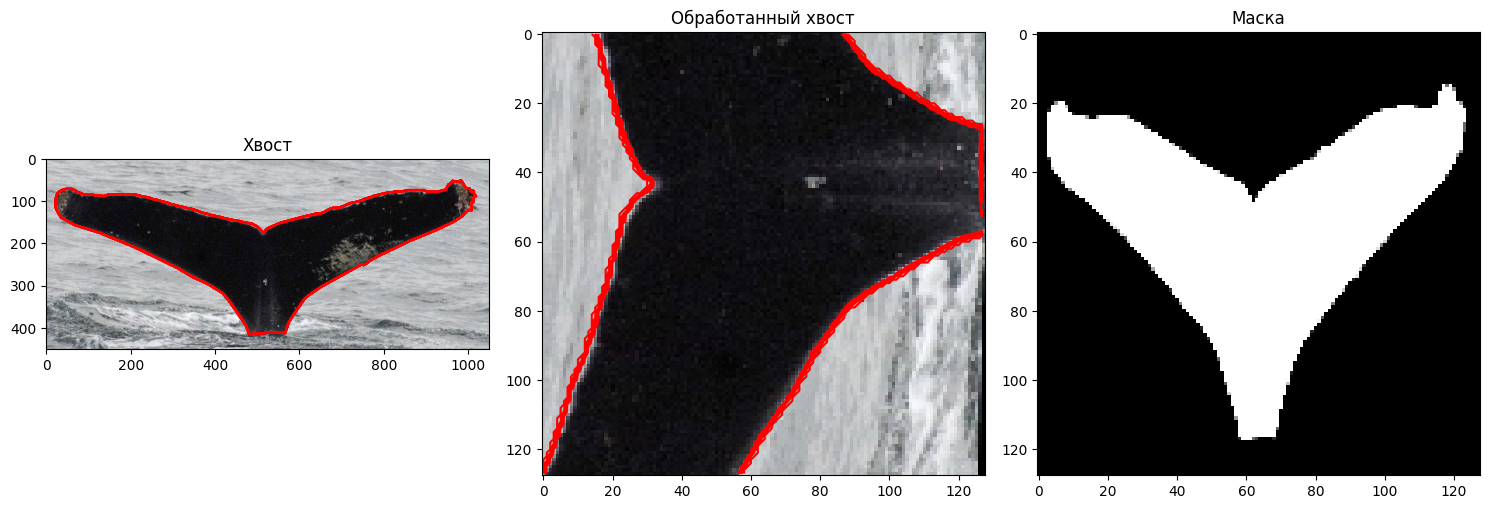

Файл: test_image_01.jpg, IoU: 0.54117742987606


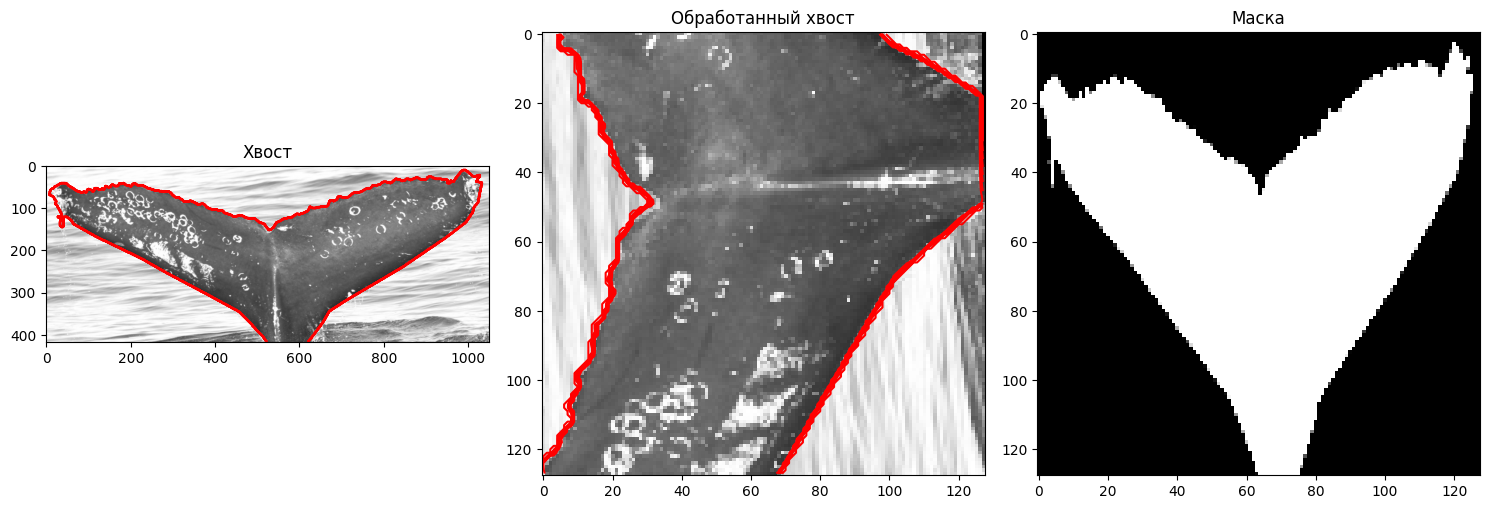

Файл: test_image_02.jpg, IoU: 0.2489830378386676


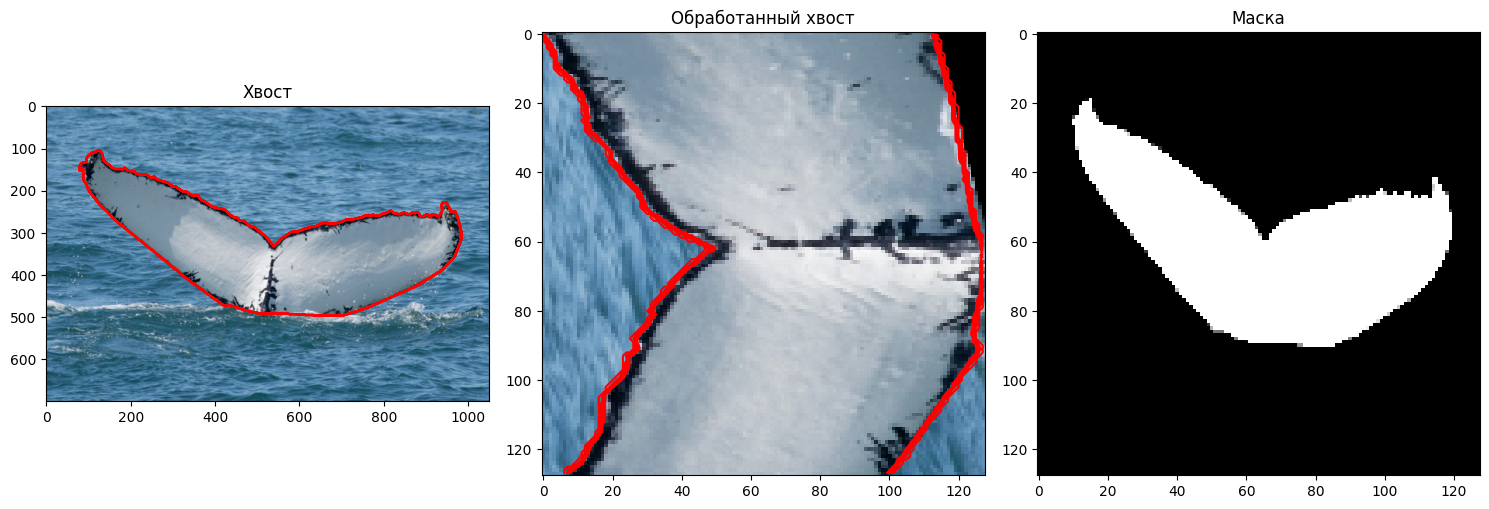

Файл: test_image_03.jpg, IoU: 0.17272518558200045


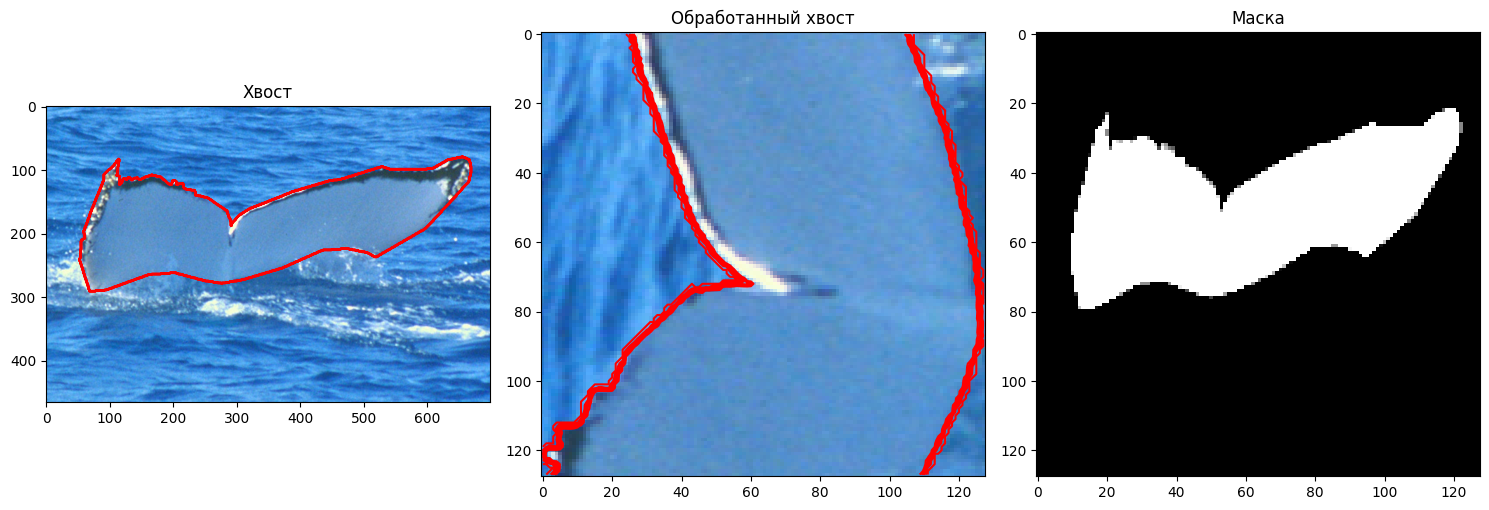

Файл: test_image_08.jpg, IoU: 0.1593209780408036


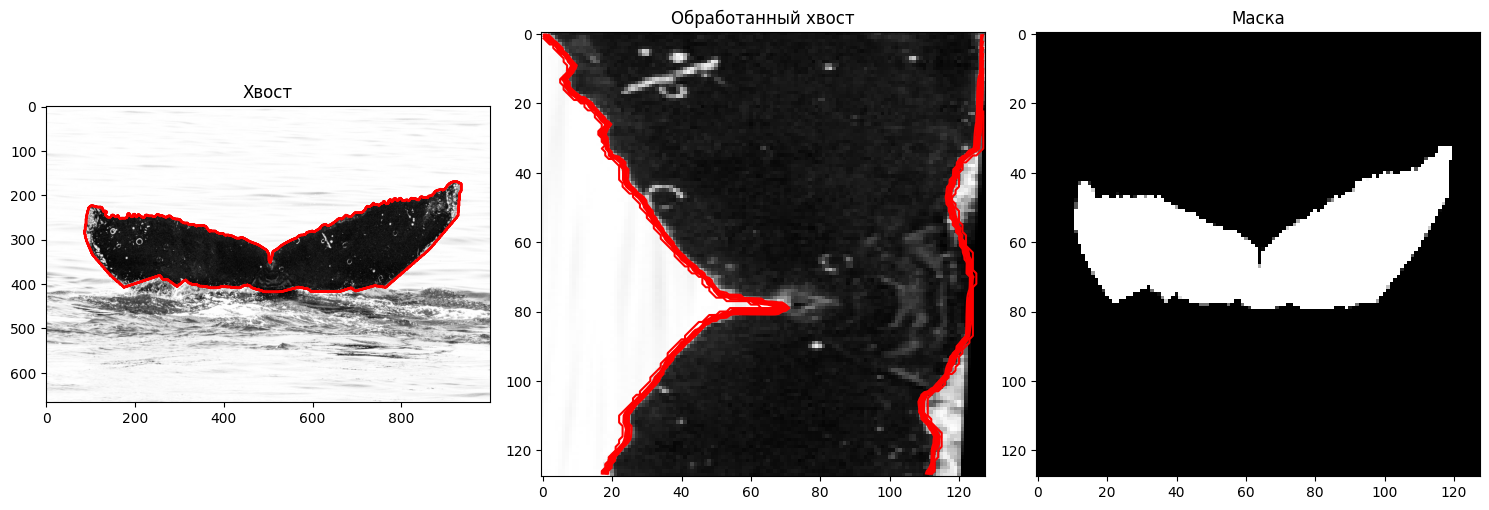

Файл: test_image_10.jpg, IoU: 0.34478340940027224


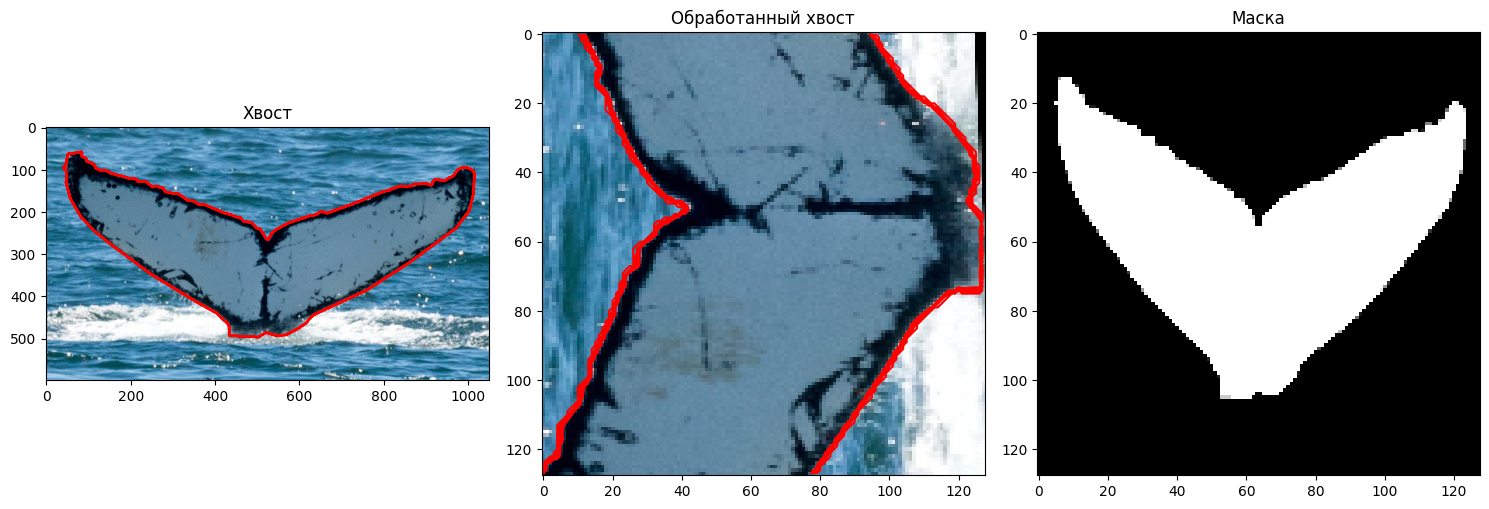

In [5]:
images_path = 'whale_tail'

process_images(images_path)

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

In [6]:
def get_map(f, g):
    _, hog_f = hog(f, orientations=8, pixels_per_cell=(20, 20),
                   cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    _, hog_g = hog(g, orientations=8, pixels_per_cell=(20, 20),
                   cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    return convolve2d(hog_f, np.flip(hog_g - np.mean(hog_g)), mode='same', boundary='fill', fillvalue=0)

def get_max_cor(hog_corr):
    h, w = hog_corr.shape
    left_half, right_half = hog_corr[:, :w // 2], hog_corr[:, w // 2:]
    max_loc1 = np.unravel_index(np.argmax(np.abs(left_half)), left_half.shape)
    max_loc2 = np.unravel_index(np.argmax(np.abs(right_half)), right_half.shape)
    return (max_loc1[0], max_loc1[1]), (max_loc2[0], max_loc2[1] + w // 2)

def process_images(reference_image_path, target_image_paths):
    reference_image = cv2.cvtColor(cv2.imread(reference_image_path), cv2.COLOR_BGR2RGB)
    for target_path in target_image_paths:
        target_image = cv2.cvtColor(cv2.imread(target_path), cv2.COLOR_BGR2RGB)
        corr_map = get_map(target_image, reference_image)
        loc1, loc2 = get_max_cor(corr_map)

        new_image = target_image.copy()
        for loc in [loc1, loc2]:
            top_left = (loc[1] - 100, loc[0] - 50)
            bottom_right = (loc[1] + 100, loc[0] + 50)
            cv2.rectangle(new_image, top_left, bottom_right, (0, 255, 0), 3)

        plt.figure()
        plt.imshow(new_image)
        plt.axis('off')

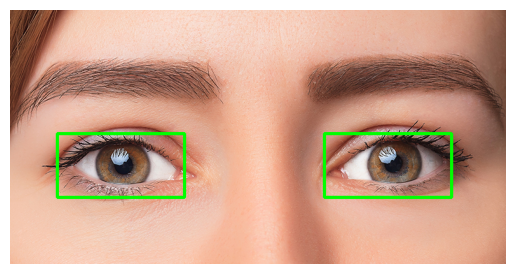

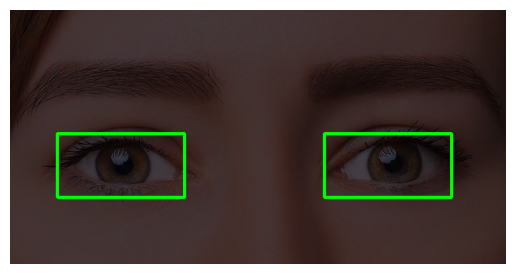

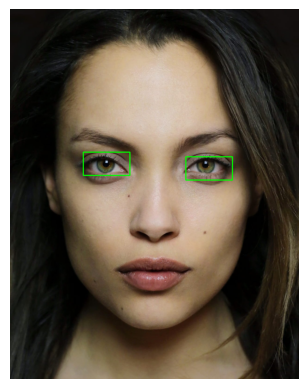

In [7]:
ref_path = './hog/eye.png'
image_path = glob.glob('./hog/*.jpg')
process_images(ref_path, image_path)